In [1]:
import pandas as pd
import numpy as np
import os,sys

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from surprise import accuracy
from surprise.dump import dump,load

from collections import defaultdict

#### Load pre-processed datasets from disk

In [3]:
def load_train_test_data(file_name,test_fold,nfolds=5):
    """
    Loads the data from csv files to train-test dataframes as per the arguments.
    Arguments:
        file_name: file to load the data from. Should not contain the fold number or extension from original file.
        test_fold: an int. This specifies the file number that should be considered as test data.
        nfolds: an int specifying the number of folds of original file on disk.
    Returns:
        Two pandas dataframes.
        Train: Contains data from all fold files except test_fold.
        Test: Contains data only from specified test_fold file.
    
    """
    folds = list(range(1,nfolds+1))
    #test_fold = 1
    test = pd.DataFrame()
    train = pd.DataFrame()
    for fold in folds:

        if fold==test_fold:
            test = pd.read_csv('data//{}{}.csv'.format(file_name,fold),delimiter='|')
        else:
            d = pd.read_csv('data//{}{}.csv'.format(file_name,fold),delimiter='|',index_col=0)
            train = pd.concat([train,d],axis = 0)
    train.reset_index(inplace=True)
    return train,test

#### Use surprise library for recommendations

In [4]:
from surprise import Reader, Dataset, KNNBasic,model_selection

In [5]:
def knn_model_performance(train,test,k,user_based=True,nfolds=5,dfname = 'tv'):

    reader = Reader(line_format='user item rating',rating_scale = (1,10))
    train_data = Dataset.load_from_df(train,reader = reader)
    test_data = Dataset.load_from_df(test,reader = reader)
    #define knn algorithm to use
    #if user_based:
    algo = KNNBasic(k=k,sim_options={'user_based':user_based})
    #else:
    #algo = KNNBasic(k=k,sim_options={'user_based':False})
    
    cv_results = model_selection.cross_validate(algo,train_data,\
                                                measures=['rmse'],cv=nfolds,n_jobs = -1,pre_dispatch=1)
    #cv_results = model_selection.cross_validate(algo,train_data,\
    #                                            measures=['rmse'],cv=nfolds)
    
    rmse_cv = sum(cv_results['test_rmse'])/nfolds
    print('RMSE Cross Validation Tests: ',cv_results['test_rmse'])
    print('Mean RMSE Cross Validation Tests: ',rmse_cv)
    
    #fit the model on full training data
    trainset = train_data.build_full_trainset()
    algo.fit(trainset)
    
    #run the model on validation testset to get predictions
    ts = test_data.build_full_trainset()
    testset = ts.build_anti_testset()
    predictions = algo.test(testset)
    if user_based:
        filtering = 'ubcf'
    else:
        filtering = 'ibcf'
    #save prediction results on disk
    file_name = '{}_{}_fold1_knn{}'.format(filtering,dfname,k)
    save_results(file_name,predictions)
    rmse_test = accuracy.rmse(predictions)
    print('RMSE of test set predictions: ',rmse_test)
    return rmse_cv, rmse_test

In [6]:
def save_results(file_name,results,algo=None):
    """
    users libraries os and surpriselib. Dumps the predictions into a specified location.
    """
    loc = 'data/dumps'
    if not os.path.exists(loc):
        os.makedirs(loc)
    dump(loc+'/'+file_name,predictions=results,algo=algo)

In [7]:
k_list = [2,4,8,16,32,64]
results = pd.DataFrame(data = None,columns = [['k','rmse_cv','rmse_test','file','method']])
loc=0

In [ ]:
#file = ['music','movies']
method_list = ['ubcf','ibcf']
for file in ['tv','music','movies','games']:
#for file in ['movies','games']:
    train,test = load_train_test_data(file,test_fold=1,nfolds=5)
        
    for method in method_list:
        print('*********Started working on database:{} and collaborative filtering: {} '.format(file,method))
        print('*'*40)
        cf = True
        if method =='ibcf':
            cf = False
            
        for k in k_list:
            print('........Calculating Results for K={}.........'.format(k))
            
            rmse_cv,rmse_test = knn_model_performance(train,test,k,user_based =cf,dfname=file)
            
            results.loc[loc]=k,rmse_cv,rmse_test,file,method
            loc+=1
    
    save_results('rmse_results_{}'.format(file),results)
    

*********Started working on database:movies and collaborative filtering: ubcf 
****************************************
........Calculating Results for K=2.........
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE Cross Validation Tests:  [ 2.58566648  2.59052285  2.58460783  2.60357651  2.58273612]
Mean RMSE Cross Validation Tests:  2.58942195882
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.1202
RMSE of test set predictions:  2.12024342916
........Calculating Results for K=4.........
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computi

### Plot the results

In [7]:
def plot_rmse(results,dfname='movies',rmse = 'test'):
    
    k = list(results[results.method=='ubcf']['k'])
    if rmse == 'test':
        ubcf = results[results.method=='ubcf']['rmse_test']
        ibcf = results[results.method=='ibcf']['rmse_test']
        title = 'RMSE results for {} Test Set'.format(dfname.capitalize())
    else:
        ubcf = results[results.method=='ubcf']['rmse_cv']
        ibcf = results[results.method=='ibcf']['rmse_cv']
        title = 'RMSE results for {} 5-fold Cross Validation'.format(dfname.capitalize())
    
    p1, = plt.plot(k,ubcf,'r',label='ubcf')
    p2, = plt.plot(k,ubcf,'ro')
    p3, = plt.plot(k,ibcf,'b',label='ibcf')
    p4, = plt.plot(k,ibcf,'bo')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('RMSE')
    plt.xticks(k)
    plt.title(title)
    #plt.ylim(1.8,2.4)
    plt.legend(handles = [p1,p3])

In [9]:
#load saved results from disk
results_movies = load('data//dumps//rmse_results_movies')
results_movies = results_movies[0]

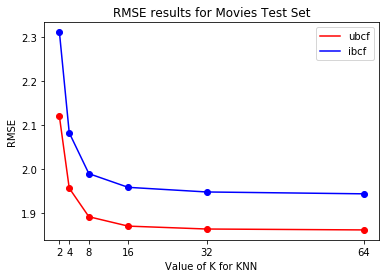

In [10]:
#plot_results(results)
plot_rmse(results_movies,'movies')

In [11]:
#load saved results from disk
results_music = load('data//dumps//rmse_results_music')
results_music = results_music[0]
results_music = results_music[results_music.file =='music']

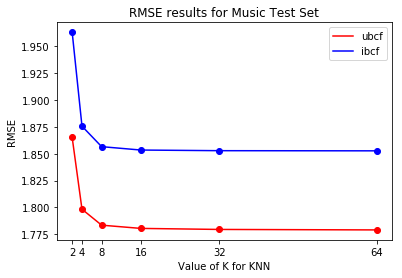

In [12]:
plot_rmse(results_music,'music')

In [13]:
#load saved results from disk
results_tv = load('data//dumps//rmse_results_tv')
results_tv = results_tv[0]

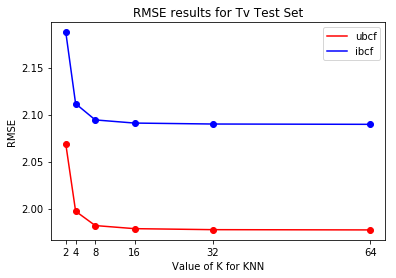

In [14]:
plot_rmse(results_tv,'tv')

#### Plot RMSE Results in one graph

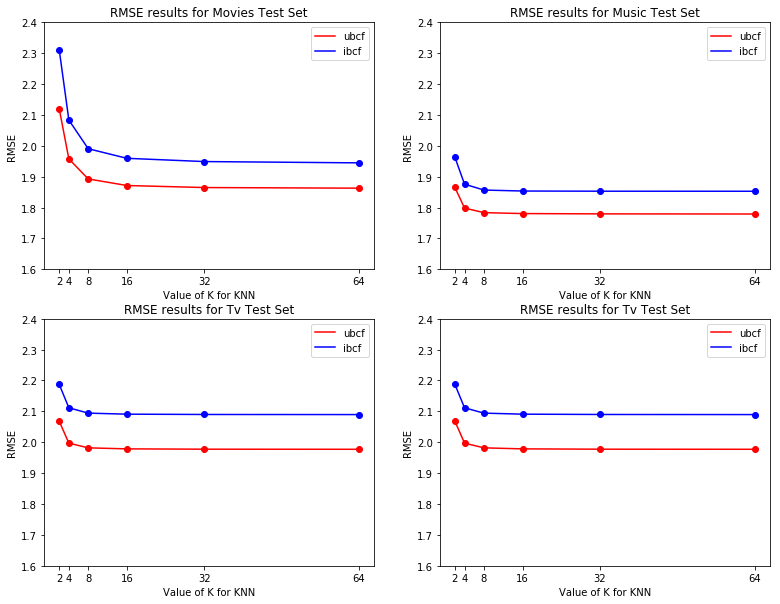

In [15]:
plt.figure(figsize=(13,10))

plt.subplot(221)
plot_rmse(results_movies,'movies')
plt.ylim(1.6,2.4)

plt.subplot(222)
plot_rmse(results_music,'music')
plt.ylim(1.6,2.4)

plt.subplot(223)
plot_rmse(results_tv,'tv')
plt.ylim(1.6,2.4)

plt.subplot(224)
plot_rmse(results_tv,'tv')
plt.ylim(1.6,2.4)

plt.show()

In [8]:
def load_predictions(filter_method,dfname,k=2):
    """
    Load predictions from the saved files on disk location.
    Arguments:
        filter_method: one of [ubcf,ibcf]
        dfname: dataset name, the dataset that needs uploading.
                Valid values ['movies','games','tv','music']
        k: number of nearest neighbors
    Returns:
        Saved Predictions data from the file specified
    """
    loc = 'data/dumps'
    file_name = '{}_{}_fold1_knn{}'.format(filter_method,dfname,k)
    data = load(loc+'/'+file_name)
    data = data[0]
    return data

In [9]:
def get_all_relevance(predictions):
    #map the prediction to each user using defaultdict(list)
    rel = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        rel[uid].append((est))
    #return rel.items()
    return rel

In [10]:
def get_user_relevances(predictions,uid):
    #map the prediction to each user using defaultdict(list)
    rel = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        rel[uid].append((est))
    
    #search for relevances of uid
    for k,v in rel.items():
        if k=='moviebuffers':
            r = v
            break
    return r

In [19]:
def dcg_at_k(r,k,method=0):
    """
    Calculate Discounted Cumulative Gain score.
    
    References:
        https://gist.github.com/bwhite/3726239
        http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf

    Arguments:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    
    r = np.asfarray(r)[:k]
    if r.size:
        if method ==0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2,r.size + 1)))
        elif method ==1:
            return np.sum(r / np.log2(np.arange(2,r.size + 2)))
        else:
            return ValueError('method must be 0 or 1.')
        
        return 0    

In [20]:
def ndcg_at_k(r, k, method=0):
    """
    Calculates Normalized Discounted Cumulative Gain score.
    
    References:
        https://gist.github.com/bwhite/3726239
        http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf

    Arguments:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        NDCG(Normalized discounted cumulative gain)
    """
    
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    
    if not dcg_max:
        return 0
    
    return dcg_at_k(r, k, method) / dcg_max
    

In [21]:
def get_top_n_predictions(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [22]:
def plot_ndcg(results, dfname='movies', K=20):
    
    k = list(results[results.method=='ubcf']['k'])
    ubcf = results[results.method=='ubcf']['ndcg']
    ibcf = results[results.method=='ibcf']['ndcg']
    title = 'NDCG Results for {} Predictions at different k-values'.format(dfname.capitalize())
    
    p1, = plt.plot(k,ubcf,'r',label='ubcf')
    p2, = plt.plot(k,ubcf,'ro')
    p3, = plt.plot(k,ibcf,'b',label='ibcf')
    p4, = plt.plot(k,ibcf,'bo')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('NDCG@{}'.format(K))
    plt.xticks(k)
    plt.title(title)
    #plt.ylim(1.8,2.4)
    plt.legend(handles = [p1,p3])

In [23]:
def get_ndcg_results(dfname,K=20):
    k_list = [2,4,8,16,32,64]
    method = ['ubcf','ibcf']
    ndcg_results = pd.DataFrame(data=None,columns=[['k','ndcg','method']])
    loc = 0
    for method in method:
        for n in k_list:
            pred = load_predictions(method,dfname,n)
            ndcg =[]
            rel = get_all_relevance(pred)
            for key,v in rel.items():
                ndcg.append(ndcg_at_k(v,K))
            mean_ndcg = np.mean(ndcg)

            ndcg_results.loc[loc] = n,mean_ndcg,method
            loc+=1
    save_results('ndcg_{}_{}'.format(dfname,K),ndcg_results)
    return ndcg_results

In [39]:
#dfname = ['movies','music','tv']
dfname = ['movies']
K = [10,20,50]
results = pd.DataFrame(data = None,columns = [['k','ndcg','method']])
for dfname in dfname:
    for n in K:
        results = pd.concat([results,get_ndcg_results(dfname,n)],axis=0)

KeyboardInterrupt: 

In [24]:
def load_and_plot_ndcg(dfname,k):
    loc = 'data/dumps'
    fn = 'ndcg_{}_{}'.format(dfname,k)
    df = load(loc + '/' + fn)[0]
    
    plot_ndcg(df,dfname,k)
    

In [25]:
ndcg_tv10 = load('data//dumps//ndcg_tv_10')[0]

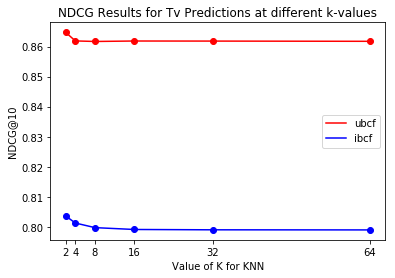

In [26]:
plot_ndcg(ndcg_tv10,'tv',10)

In [27]:
plot_ndcg(ndcg_results,'tv',20)

NameError: name 'ndcg_results' is not defined

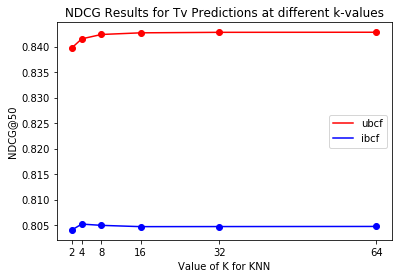

In [28]:
load_and_plot_ndcg('tv',50)

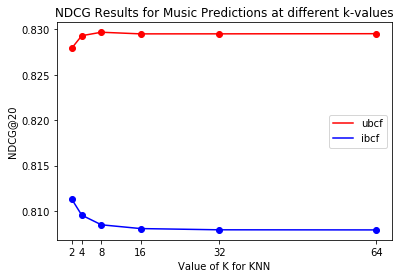

In [29]:
load_and_plot_ndcg('music',20)

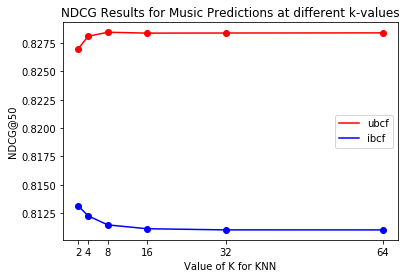

In [30]:
load_and_plot_ndcg('music',50)

### Plot NDCG Results in one plot

In [31]:
def plot_all_in_one(plot_function,no_of_items=50):
    
    plt.figure(figsize=(12,10))
    plt.subplot(221)
    plot_function('movies',no_of_items)
    plt.ylim(0.70,0.90)
    
    plt.subplot(222)
    #plot_function('games',no_of_items)
    plot_function('movies',no_of_items)
    plt.ylim(0.70,0.90)
    
    plt.subplot(223)
    plot_function('music',no_of_items)
    plt.ylim(0.70,0.90)
    
    plt.subplot(224)
    plot_function('tv',no_of_items)
    plt.ylim(0.70,0.90)
    
    plt.show()

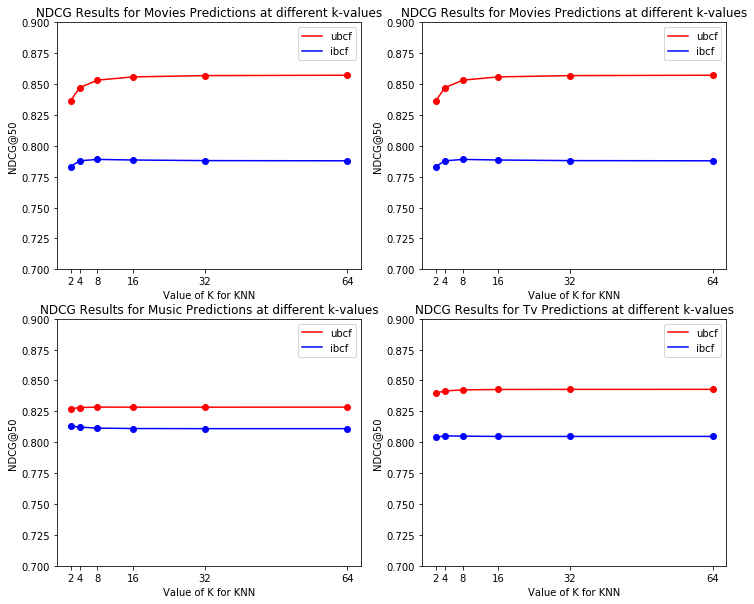

In [32]:
plot_all_in_one(load_and_plot_ndcg,50)

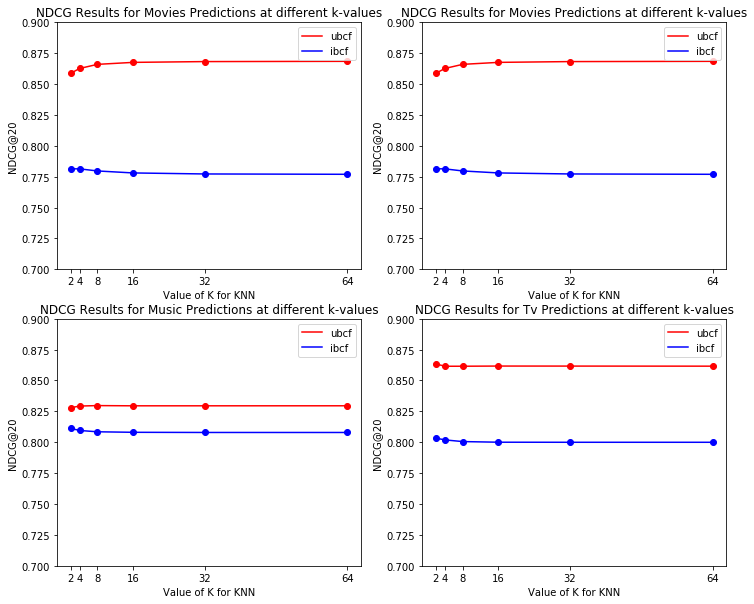

In [33]:
plot_all_in_one(load_and_plot_ndcg,20)

In [49]:
train,test = load_train_test_data('games',1)

In [50]:
train.user_id.nunique()

13368

In [51]:
train.item_id.nunique()

5701

In [52]:
mtrain,mtest = load_train_test_data('movies',1)

In [53]:
mtrain.user_id.nunique()

3725

In [54]:
mtest.item_id.nunique()

3063